# Air Quality Prediction Using Autoregressive Model

# Problem Statement

Air pollution, particularly fine particulate matter (PM2.5), poses significant health risks, including respiratory and cardiovascular diseases. Accurate forecasting of PM2.5 levels is crucial for timely interventions, policy formulation, and public health awareness.

In Nairobi, fluctuating pollution levels due to factors such as traffic congestion, industrial activities, and weather patterns make real-time monitoring and prediction essential. However, existing air quality monitoring systems often lack predictive capabilities, limiting proactive decision-making.

This project aims to develop an autoregressive time series model to predict PM2.5 concentrations based on historical sensor data. By leveraging past pollution levels, the model will identify patterns and correlations that can enhance forecasting accuracy. The insights from this study will aid policymakers, environmental agencies, and the public in mitigating air pollution’s adverse effects.

In [41]:
#Import libraries
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AutoReg
import pytz

warnings.simplefilter(action="ignore", category=FutureWarning)

In [42]:
#Load data
files = [
    r'C:\Users\hp\Desktop\AIR_QUALITY_PROJECT\2018\september_2018_sensor_data_archive.csv',
    r'C:\Users\hp\Desktop\AIR_QUALITY_PROJECT\2018\october_2018_sensor_data_archive.csv',
    r'C:\Users\hp\Desktop\AIR_QUALITY_PROJECT\2018\november_2018_sensor_data_archive.csv'
    
]
nairobi = pd.concat(
    [pd.read_csv(file, sep=";", dtype=str, low_memory=False) for file in files], #low_memory =false to import all data in string type
    ignore_index=True
)

In [43]:
nairobi.head()

,sensor_id,sensor_type,location,lat,lon,timestamp,value_type,value
0,57,SDS011,29,-1.300,36.785,2018-09-01T00:00:02.472867+00:00,P2,34.43
1,57,SDS011,29,-1.300,36.785,2018-09-01T00:00:02.472867+00:00,P1,39.67
2,58,DHT22,29,-1.300,36.785,2018-09-01T00:00:04.301785+00:00,humidity,83.40
3,58,DHT22,29,-1.300,36.785,2018-09-01T00:00:04.301785+00:00,temperature,16.50
4,69,SDS011,7,-1.298,36.791,2018-09-01T00:00:07.536156+00:00,P2,16.63


In [44]:
#Convert value and sensor id to numeric dtype
numeric_cols = ["sensor_id", "value"]  
for col in numeric_cols:
    nairobi[col] = pd.to_numeric(nairobi[col], errors="coerce")

In [45]:
#convert timestamp column to datetime
nairobi["timestamp"] = pd.to_datetime(nairobi["timestamp"], errors="coerce")

Subset the data to select data from the sensor that has highest numeber of PM2.5 reading.

In [46]:
#Select sensor type that has the most P2 reading from the dataset
p2_counts = nairobi[nairobi['value_type'] == 'P2']['sensor_id'].value_counts()

# Get the sensor with the most P2 readings
most_p2_sensor = p2_counts.idxmax()
max_p2_count = p2_counts.max()

print(f"Sensor {most_p2_sensor} has the most P2 readings: {max_p2_count}")


Sensor 51 has the most P2 readings: 49212


In [47]:
nairobi.shape

(2634833, 8)

## Data Wrangling

In [48]:
#Develop a wrngle function
def wrangle(df):
    # Filter for sensor_id 156 and value_type "P2"
    df = df[(df["sensor_id"] == 51) & (df["value_type"] == "P2")]

    # Rename 'value' column to 'P2'
    df = df.rename(columns={"value": "P2"}).drop(columns=["value_type"])
    
    # Set timestamp as index and keep only 'P2'
    df = df.set_index("timestamp")[["P2"]]
    
    #localize timezone
    df.index = pd.to_datetime(df.index)
    df = df.tz_convert("Africa/Nairobi")
    
    df['P2'] = pd.to_numeric(df['P2'], errors='coerce')  
    df = df.dropna(subset=['P2'])  
    
    #Remove outlier
    df = df[df['P2']< 100]
    
    #Resample the data to provide the mean PM2.5 reading for each hour
    df = df['P2'].resample('1H').mean().fillna(method='ffill').to_frame()


    return df
    

In [49]:
# Call the function
df = wrangle(nairobi)
print(df)

                                  P2
timestamp                           
2018-09-01 03:00:00+03:00  16.142500
2018-09-01 04:00:00+03:00  16.567500
2018-09-01 05:00:00+03:00  12.747391
2018-09-01 06:00:00+03:00  15.055417
2018-09-01 07:00:00+03:00  25.797500
...                              ...
2018-11-30 22:00:00+03:00  16.074211
2018-11-30 23:00:00+03:00  31.839444
2018-12-01 00:00:00+03:00  17.252105
2018-12-01 01:00:00+03:00  12.720000
2018-12-01 02:00:00+03:00  10.854737

[2184 rows x 1 columns]


In [50]:
df.shape

(2184, 1)

<Axes: title={'center': 'Distribution of PM2.5 Readings'}>

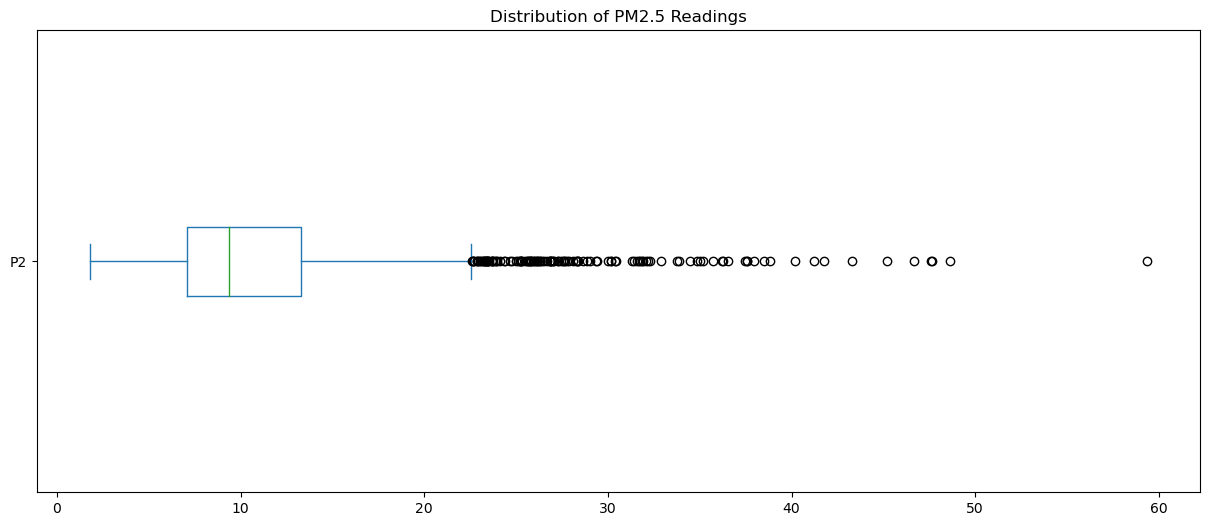

In [51]:
#Plot box plot to identify outliers
fig, ax = plt.subplots(figsize=(15, 6))
df['P2'].plot(kind='box', vert=False, title='Distribution of PM2.5 Readings', ax=ax)

## Plot timeseries plot for average PM2.5 reading per hour

<Axes: title={'center': 'Nairobi PM2.5'}, xlabel='Date', ylabel='PM2.5 Level'>

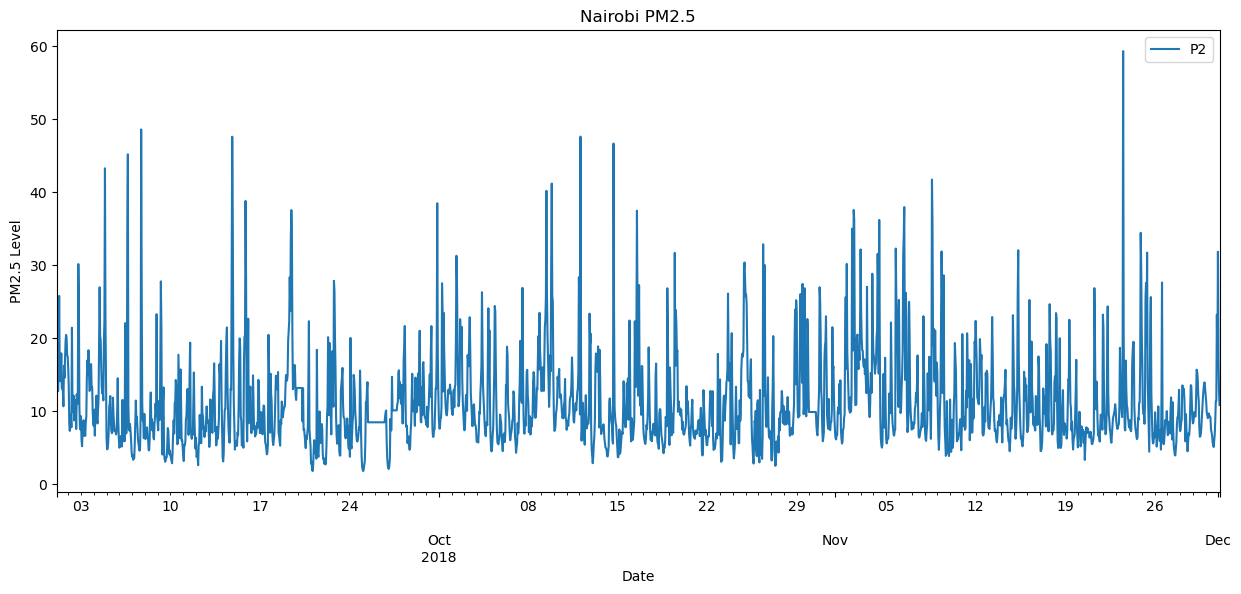

In [52]:
#Plot time series plot for average PM2.5 reading per hour
fig, ax = plt.subplots(figsize=(15, 6))
df.plot(xlabel= 'Date', ylabel= 'PM2.5 Level', title="Nairobi PM2.5", ax=ax)

**Apply a rolling average to smooth fluctuations in the dataset and identify potential trends.**

- A rolling average (also known as a moving average) calculates the mean of multiple subsets of numbers within a dataset, helping to smooth out short-term variations.

- In this case, we compute the rolling average of the readings in the DataFrame using a window size of 168 (equivalent to the number of hours in a week). 

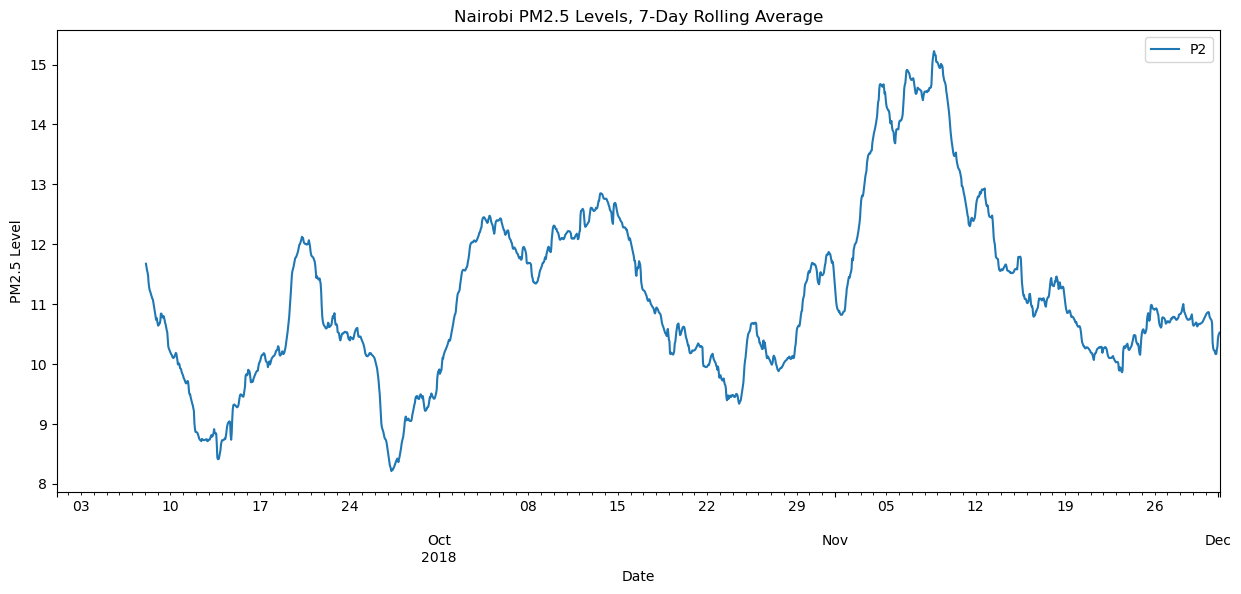

In [54]:
fig, ax = plt.subplots(figsize=(15, 6))
df.rolling(168).mean().plot(ax=ax, xlabel='Date', ylabel='PM2.5 Level', title='Nairobi PM2.5 Levels, 7-Day Rolling Average');

## Explore Data

**Plot An Autocorrelation Function(ACF)**

- An Autocorrelation Function (ACF) plot is a visual tool used in time series analysis to measure and display the correlation    between a time series and its past values (lags). It helps determine how past observations influence future ones and is essential in identifying significant lags for modeling.
- Let's plot an ACF plot to show us how many lags we should include in our model to achieve good predictive power

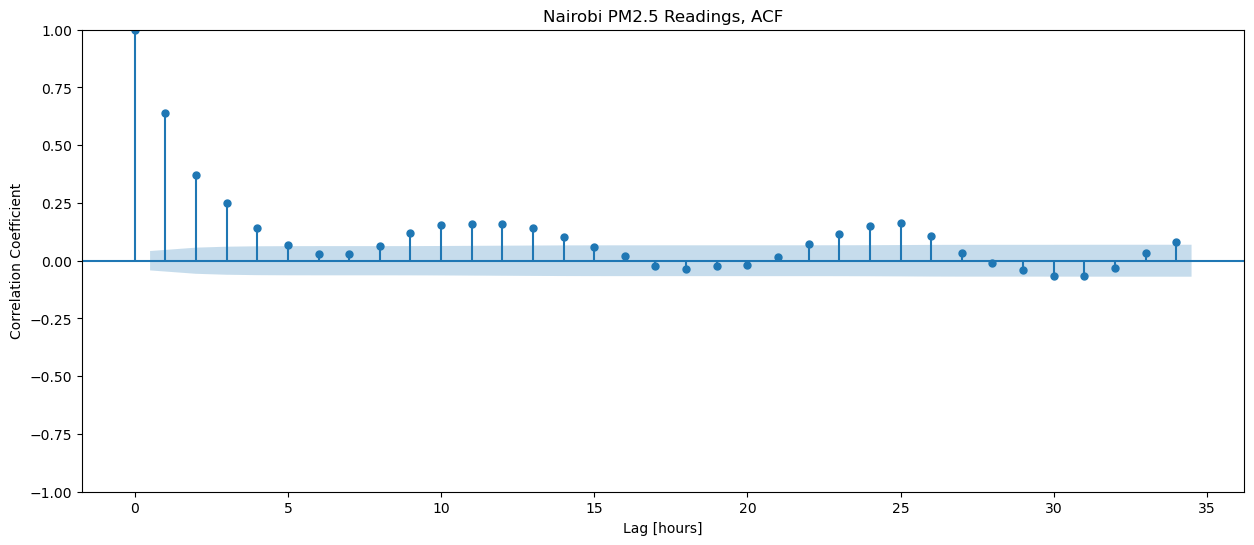

In [19]:
fig, ax = plt.subplots(figsize=(15, 6))
plot_acf(df, ax=ax)
plt.xlabel("Lag [hours]")  
plt.ylabel("Correlation Coefficient")
plt.title("Nairobi PM2.5 Readings, ACF");

- We can see a strong correlation between the current observations and those from an hour ago.
- There are additional peaks at 12 hours and 24 hours, indicating that past values from 24 hours ago have predictive power.


**Plot a Partial Autocorrelation function**

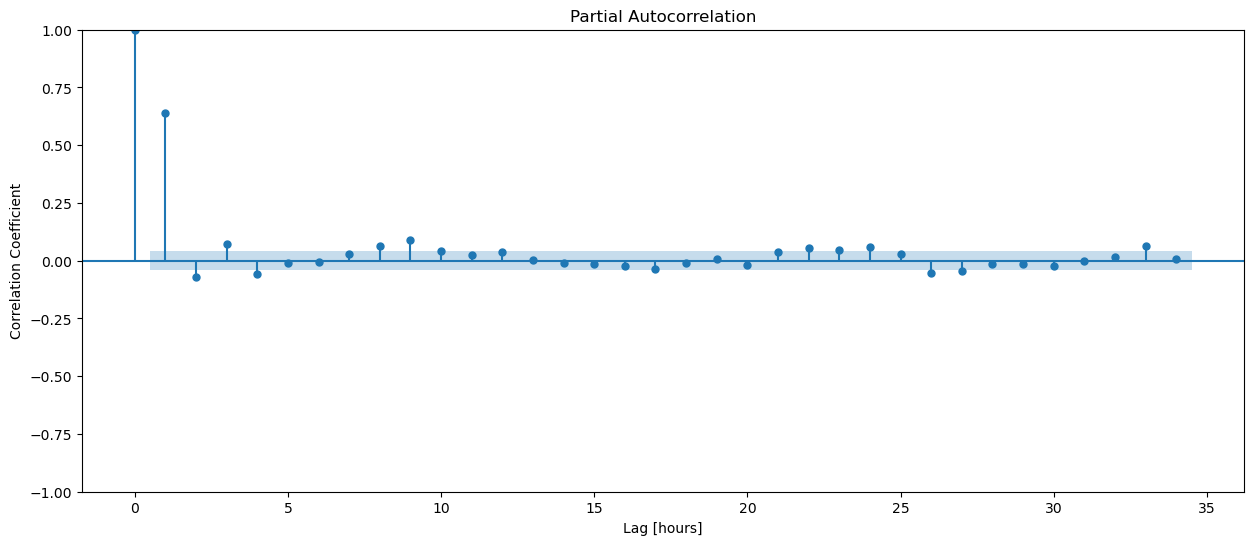

In [55]:
#PACF plot will show us the right lag that has predictive power 
fig, ax = plt.subplots(figsize=(15, 6))
plot_pacf(df, ax=ax)
plt.xlabel("Lag [hours]")
plt.ylabel("Correlation Coefficient");

- We can see that there is correlation of around 0.7 in our data at lag 1 - meaning what happened in the last hour has strong power of predicting what is  happening now.
- At 12hours & 24 hours there is a peak. Meaning that what happened 24 hours has some predictive power.
- This helps us determine the number of lags to include in our model.

# Train Autoregressive Model

## Split Data to train and test data

In [56]:
#Split y into training and test sets. The first 90% of the data should be in your training set. 
#The remaining 10% should be in the test set.
cutoff_test = int(len(df)* 0.90)

df_train = df.iloc[:cutoff_test]
df_test = df.iloc[cutoff_test:]
print("df_train shape:", df_train.shape)
print("df_test shape:", df_test.shape)

df_train shape: (1965, 1)
df_test shape: (219, 1)


In [57]:
#Lets estabish baseline mean absolute error for the model
df_train_mean = df_train.mean()
df_pred_baseline = [df_train_mean] * len(df_train)
mae_baseline = mean_absolute_error(df_train, df_pred_baseline)

print("Mean P2 Reading:", df_train_mean)
print("Baseline MAE:", mae_baseline)

Mean P2 Reading: P2    11.178751
dtype: float64
Baseline MAE: 4.601705559581848


## Fit Autoreg Model

In [58]:
target_col = 'P2'  

# Fit the AutoReg model
model = AutoReg(df_train[target_col], lags=26).fit()

# Predict values (start prediction at index 26)
y_pred = model.predict(start=26, end=len(df_train)-1)

# Convert y_pred to a Series with the correct index
y_pred = pd.Series(y_pred.values, index=df_train.index[26:])

# Compute residuals (actual - predicted)
residuals = df_train[target_col].iloc[26:] - y_pred

# Print residuals (dropping NaN values)
print("Residuals:")
print(residuals.dropna())

# Compute Training MAE
training_mae = mean_absolute_error(df_train[target_col].iloc[26:], y_pred)
print("Training MAE:", training_mae)


Residuals:
timestamp
2018-09-02 05:00:00+03:00    -1.165384
2018-09-02 06:00:00+03:00    -3.265900
2018-09-02 07:00:00+03:00    11.190235
2018-09-02 08:00:00+03:00    -9.783656
2018-09-02 09:00:00+03:00     0.306819
                               ...    
2018-11-21 19:00:00+03:00    -0.103936
2018-11-21 20:00:00+03:00    -1.585090
2018-11-21 21:00:00+03:00    -1.135885
2018-11-21 22:00:00+03:00    -1.892714
2018-11-21 23:00:00+03:00    14.741875
Freq: H, Length: 1939, dtype: float64
Training MAE: 2.9674313840786866


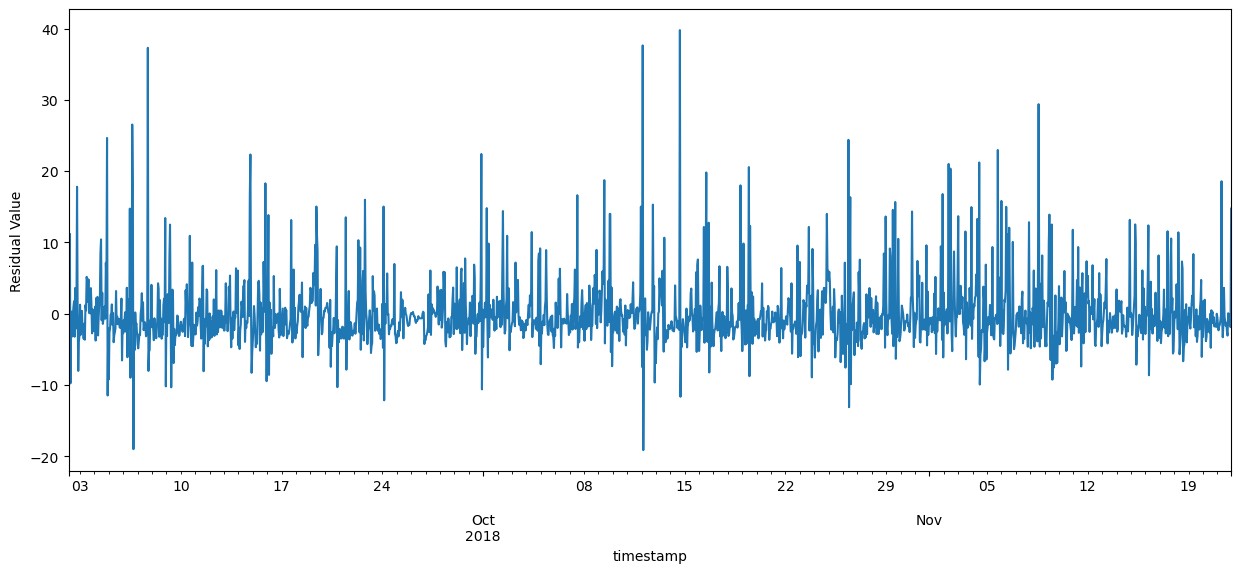

In [59]:
fig, ax = plt.subplots(figsize=(15, 6))
residuals.plot(ylabel='Residual Value', ax=ax);

Text(0.5, 1.0, 'AR(26), Distribution of Residual')

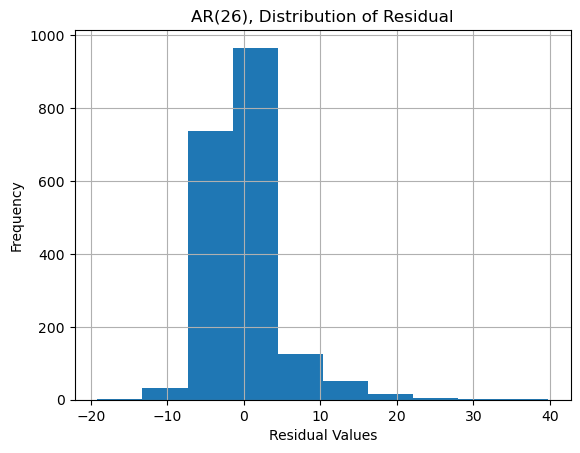

In [60]:
#plot histogram of the residuals
residuals.hist()
plt.xlabel('Residual Values')
plt.ylabel('Frequency')
plt.title('AR(26), Distribution of Residual')

    - The residuals are normally distributed

In [61]:
#Calculate the test mean absolute error
y_pred_test = model.predict(df_test.index.min(), df_test.index.max())
test_mae = mean_absolute_error(df_test, y_pred_test)
print("Test MAE:", test_mae)


Test MAE: 3.9888166503277205


In [29]:
y_pred_test = model.predict(start=df_test.index[0], end=df_test.index[-1])
test_mae = mean_absolute_error(df_test.squeeze(), y_pred_test)
print("Test MAE:", test_mae)


Test MAE: 3.9888166503277205


In [62]:
#Create a DataFrame test_predictions that has two columns: "y_test" and "y_pred"
# Ensure y_test and y_pred are 1D arrays
y_test = df_test.squeeze()  # Convert DataFrame to Series if needed
y_pred = y_pred_test.squeeze()

# Create DataFrame
test_predictions = pd.DataFrame({"y_test": y_test, "y_pred": y_pred}, index=df_test.index)

# Display DataFrame
print(test_predictions.head())


                              y_test     y_pred
timestamp                                      
2018-11-22 00:00:00+03:00  21.422500  18.671846
2018-11-22 01:00:00+03:00  12.851250  12.917800
2018-11-22 02:00:00+03:00   9.300000  12.356154
2018-11-22 03:00:00+03:00   7.750833  10.840717
2018-11-22 04:00:00+03:00   6.844783   9.519359


In [64]:
#Create a time series plot for the values in test_predictions using plotly express. 
#Be sure that the y-axis is properly labeled as "P2".
fig = px.line(test_predictions, labels={"value": "P2"})
fig.show();

- The model is not performing well because it relies on the past 26 data points for predictions. As it progresses, it starts by using 25 actual data points and one predicted point. This pattern continues until the model is entirely dependent on its own predictions rather than actual data. As a result, errors accumulate, leading to a breakdown in accuracy, which explains why the plot deteriorates.

**Perform a Walk forward Validation for the entire y_test**


In [65]:
#Perform walk-forward validation for your model for the entire test set y_test. 
#Store your model's predictions in the Series y_pred_wfv
y_pred_wfv = pd.Series()
history = df_train.copy()
for i in range(len(y_test)):
    model = AutoReg(history, lags=26).fit()
    next_pred = model.forecast()
    y_pred_wfv = pd.concat([y_pred_wfv, next_pred])  
    history = pd.concat([history, df_test.loc[next_pred.index]])

In [66]:
#Calculate the test mean absolute error for your model.
test_mae = mean_absolute_error(y_test, y_pred_wfv)
print("Test MAE (walk forward validation):", round(test_mae, 2))

Test MAE (walk forward validation): 2.82


In [67]:
#Put the values for y_test and y_pred_wfv into the DataFrame df_pred_test (don't forget the index). Then plot df_pred_test using plotly express.
df_pred_test = pd.DataFrame(
    {'y_test': y_test, 'y_pred_wfv': y_pred_wfv
    }

)
fig = px.line(df_pred_test, labels={'value' : 'PM2.5'})
fig.show()

# Next Steps
- Add more Data
- Deploy the model